In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

import sscCdi
from sscCdi import unwrap_in_parallel, equalize_frames_parallel, make_bad_frame_null
import sscRadon

%matplotlib widget

In [3]:
# path = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/glass_sphere/2023-07-28-17h04m_glass_sphere.hdf5"
# data = h5py.File(path,'r')['recon/object'][()]
# angles = h5py.File(path,'r')['recon/angles'][()][:,0::2]
# data=data[:,1350:-1300,1200:-1400]


path = "/ibira/lnls/beamlines/caterete/proposals/20221798/proc/recons/sorgoBMR08_mem1_FAA_YuriTest/YuriTest_sorgoBMR08_mem1_FAA.hdf5"
data = h5py.File(path,'r')['recon/object'][()]
angles = h5py.File(path,'r')['recon/angles'][()][:,0::2]
data=data[:,1345:3040,1280:2980]


# path = "/ibira/lnls/beamlines/caterete/proposals/20221798/proc/recons/sorgoWT05_mem2_FAA_01/2023-07-25-14h54m_sorgoWT05_mem2_FAA_01.hdf5"
# data = h5py.File(path,'r')['recon/object'][()]
# angles = h5py.File(path,'r')['recon/angles'][()][:,0::2]
# data=data[:,1300:-1500,1300:-1500]
# data.shape



In [4]:
from sscCdi import sort_angles
from sscCdi import reorder_slices_low_to_high_angle

sorted_angles = sort_angles(angles) # input colums with frame number and angle in rad
data = reorder_slices_low_to_high_angle(data, sorted_angles)

In [5]:
sscCdi.misc.deploy_visualizer(np.angle(data),title='sample',cmap='gray',axis=0)

In [13]:
dic={}
dic["bad_frames_before_equalization"] = []

dic["CPUs"] = 64
dic["equalize_invert"] = True # invert phase shift signal from negative to positive
dic["equalize_ROI"] = [0,1550,1500,1600] # region of interest of null region around the sample used for phase ramp and offset corrections
dic["equalize_remove_phase_gradient"] = True  # if empty and equalize_ROI = [], will subtract best plane fit from whole image
dic["equalize_set_min_max"]= [] # [minimum,maximum] threshold values for whole volume
dic["equalize_non_negative"] = True # turn any remaining negative values to zero
dic["equalize_local_offset"] = False # remove offset of each frame from the mean of ROI 

In [10]:
unwrapped_sinogram = unwrap_in_parallel(np.angle(data))

Using 32 parallel processes


100%|██████████| 510/510 [01:07<00:00,  7.58it/s]


In [14]:
equalized_sinogram = equalize_frames_parallel(unwrapped_sinogram,dic)
# equalized_sinogram = np.where(equalized_sinogram<-0.6,0,equalized_sinogram)
sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray')

Sinogram shape to unwrap:  (510, 1695, 1700)
Using 64 parallel processes


100%|██████████| 510/510 [03:21<00:00,  2.53it/s]


Min 	 Mean-3*sigma 	 Mean 	 Mean+3*sigma 	 Max 
Old 0.00, -20.42, 4.61, 29.63,38.05
New: 0.00, -11.13,1.01, 13.16,128.63


In [16]:
sscCdi.misc.deploy_visualizer(equalized_sinogram[3::],title='sample',cmap='gray')

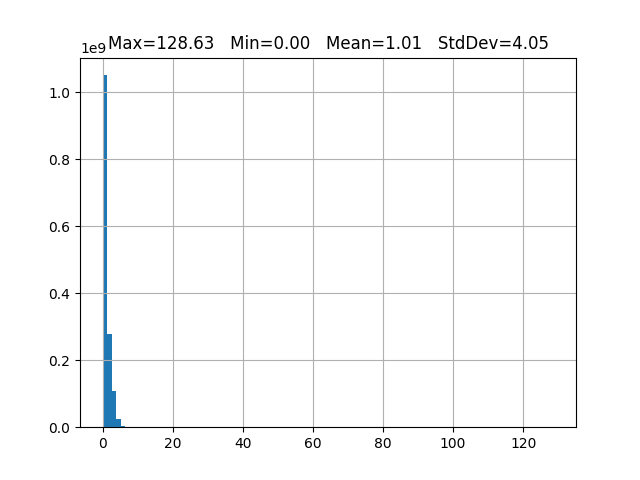

In [15]:
from sscCdi import plot_volume_histogram

plot_volume_histogram(equalized_sinogram)

In [12]:
dic["CPUs"] = 32 
dic["wiggle_reference_frame"] = 50

temp_tomogram, shift_vertical = sscRadon.radon.get_wiggle( equalized_sinogram, "vertical", dic["CPUs"], dic["wiggle_reference_frame"] )
# temp_tomogram, shift_vertical = sscRadon.radon.get_wiggle( temp_tomogram, "vertical", dic["CPUs"], dic["wiggle_reference_frame"] )

ssc-radon: creating 250x1695x1700 shared arrays (tomogram)


In [13]:
sscCdi.misc.deploy_visualizer(temp_tomogram,title='sample',cmap='gray',axis=0)

In [14]:
aligned_sinogram, shift_horizontal, wiggle_cmas_temp = sscRadon.radon.get_wiggle( temp_tomogram, "horizontal", dic["CPUs"], dic["wiggle_reference_frame"] )

ssc-radon: creating 250x1695x1700 shared arrays (tomogram)


In [15]:
sscCdi.misc.deploy_visualizer(temp_tomogram,title='sample',cmap='gray',axis=1)

In [16]:
sscCdi.misc.deploy_visualizer(aligned_sinogram,title='sample',cmap='gray',axis=1)

In [17]:
sscCdi.misc.deploy_visualizer(temp_tomogram,title='sample',cmap='gray',axis=2)

In [18]:
sscCdi.misc.deploy_visualizer(aligned_sinogram,title='sample',cmap='gray',axis=2)

## Cross Correlation of Variance Field 

In [6]:
sscCdi.misc.deploy_visualizer(np.angle(data),title='sample',cmap='gray',axis=0)

In [13]:
cropped_aligned_volume = alignment_variance_field(data, fft_upsampling=10,return_common_valid_region=True, remove_null_borders = True)

# idx_to_delete = [28,30,45,49,65,66,91,113]
# cropped_aligned_volume = np.delete(cropped_aligned_volume,idx_to_delete,axis=0)
# sscCdi.misc.deploy_visualizer(np.angle(cropped_aligned_volume),title='sample',cmap='gray')

Finding shift between neighboor slices...
Shifting slice #0
Shifting slice #10
Shifting slice #20
Shifting slice #30
Shifting slice #40
Shifting slice #50
Shifting slice #60
Shifting slice #70
Shifting slice #80
Shifting slice #90
Shifting slice #100
Shifting slice #110
Shifting slice #120
Shifting slice #130
Shifting slice #140
Shifting slice #150
Shifting slice #160
Shifting slice #170
Shifting slice #180
Shifting slice #190
Shifting slice #200
Shifting slice #210
Shifting slice #220
Shifting slice #230
Shifting slice #240
Shifting slice #250
Shifting slice #260
Shifting slice #270
Shifting slice #280
Shifting slice #290
Shifting slice #300
Shifting slice #310
Shifting slice #320
Shifting slice #330
Shifting slice #340
Shifting slice #350
Shifting slice #360
Shifting slice #370
Shifting slice #380
Shifting slice #390
Shifting slice #400
Shifting slice #410
Shifting slice #420
Shifting slice #430
Shifting slice #440
Shifting slice #450
Shifting slice #460
Shifting slice #470
Shifting 

In [15]:
unwrapped_sinogram = unwrap_in_parallel(np.angle(cropped_aligned_volume))

Using 32 parallel processes


100%|██████████| 510/510 [00:53<00:00,  9.51it/s]


NameError: name 'dic' is not defined

In [25]:
equalized_sinogram = equalize_frames_parallel(unwrapped_sinogram,dic["equalize_invert"],dic["equalize_gradient"],dic["equalize_outliers"],dic["equalize_global_offset"], dic["equalize_local_offset"])

Sinogram shape to unwrap:  (510, 1582, 1436)
Using 32 parallel processes


100%|██████████| 510/510 [00:37<00:00, 13.68it/s]


Min 	 Mean-3*sigma 	 Mean 	 Mean+3*sigma 	 Max 
Old  -6.761463948045657 -11.725555189538648 1.0854881071248113 13.896531403788272 18.20038971483409
New  -7.9520745 -2.603372097015381 1.0275024 4.658376932144165 18.50625


In [26]:
sscCdi.misc.deploy_visualizer(equalized_sinogram[10:500],title='sample',cmap='gray')

In [27]:
sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray',axis=1)

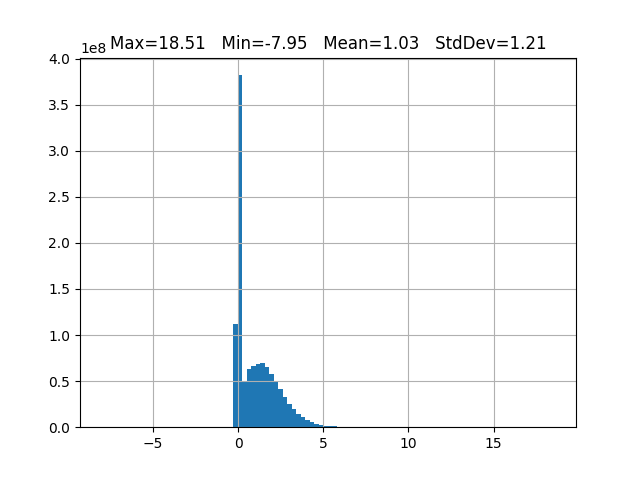

In [37]:
def plot_volume_histogram(volume,bins=100):
    
    maximum = np.max(volume)
    minimum = np.min(volume)
    mean    = np.mean(volume)
    stddev  = np.std(volume)
    
    fig, ax = plt.subplots()
    ax.hist(volume.flatten(),bins=bins)
    ax.grid()
    ax.set_title(f'Max={maximum:.2f}   Min={minimum:.2f}   Mean={mean:.2f}   StdDev={stddev:.2f}')
    
plot_volume_histogram(equalized_sinogram)

In [17]:
sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray',axis=2)

In [ ]:
def plot_sinogram_slices(sinogram,cmap='gray'):
    shape = sinogram.shape
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    ax[0].imshow(sinogram[:,shape[1]//2,:],cmap=cmap)
    ax[1].imshow(sinogram[:,:,shape[2]//2],cmap=cmap)    
    
plot_sinogram_slices(equalized_sinogram)

## Vertical mass fluctuation

In [ ]:
aligned_volume2 = alignment_vertical_mass_fluctuation(cropped_aligned_volume, use_phase_gradient = False, plot = True)

In [ ]:
sscCdi.misc.deploy_visualizer(np.angle(aligned_volume2),title='sample',cmap='gray')

In [ ]:
sscCdi.misc.deploy_visualizer(np.angle(aligned_volume2),title='sample',cmap='gray',axis=2)

In [ ]:
sscCdi.misc.deploy_visualizer(np.angle(cropped_aligned_volume),title='sample',cmap='gray',axis=2)

In [ ]:
unwrapped_volume = unwrap_in_parallel(np.angle(aligned_volume2))
unwrapped_volume = unwrapped_volume[:,100::,:]

sscCdi.misc.deploy_visualizer(unwrapped_volume,title='sample',cmap='gray')

In [24]:
dic = {}
dic["bad_frames_before_unwrap"] = []#[28,30,45,49,65,66,91,113]
dic["equalize_gradient"] = [True,[1400,1500,0,1500],0]
dic["equalize_global_offset"] = False
dic["equalize_invert"] = True
dic["equalize_local_offset"] = [1400,1500,0,1500]
dic["equalize_outliers"] = 0

# equalized_sinogram = equalize_frames_parallel(unwrapped_volume,dic["equalize_invert"],dic["equalize_gradient"],dic["equalize_outliers"],dic["equalize_global_offset"], dic["equalize_local_offset"])
# sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray')

In [ ]:
sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray',axis=2)

In [ ]:
sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray',axis=1)